In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import scipy.stats as stats

In [39]:
use_liberation_fonts = True
if use_liberation_fonts:
    plt.rcParams.update({
        'font.family':'sans-serif',
        'font.sans-serif':['Liberation Sans'],
    })

## SENTINEL-2 BATHYMETRY ANALYSIS

# NUORGAM

# Calibration from ASV (N=50) and Lyzenga's model (78)

In [2]:
# import NUORGAM (n) CALIBRATION POINTS (c)
n_c = pd.read_csv('../data/output/satellite-analysis/nuorgam_calibrationpoints_2.csv', delimiter=',')

In [3]:
# check
n_c.head()

,id,SAMPLE_1,SAMPLE_2,SAMPLE_1_2,SAMPLE_2_2,SAMPLE_3,SAMPLE_4,SAMPLE_5,SAMPLE_6,SAMPLE_7,...,SAMPLE_20,SAMPLE_21,SAMPLE_22,SAMPLE_23,SAMPLE_1_3,SAMPLE_2_3,SAMPLE_3_2,SAMPLE_4_2,SAMPLE_5_2,SAMPLE_6_2
0,0,-1.549120,1.549120,0.1322,0.1244,0.1250,0.1197,0.1218,0.1195,0.1220,...,0,0,0,0,11.60,11.72,11.667500,11.667301,4,0.044371
1,1,-2.663183,2.663183,0.1250,0.1239,0.1234,0.1151,0.1144,0.1142,0.1138,...,0,0,0,0,NaN,NaN,NaN,NaN,0,NaN
2,2,-1.480504,1.480504,0.1277,0.1254,0.1270,0.1208,0.1214,0.1147,0.1210,...,0,0,0,0,11.67,13.28,12.053333,12.021470,9,0.655862
3,3,-1.449683,1.449683,0.1277,0.1256,0.1278,0.1192,0.1189,0.1164,0.1167,...,0,0,0,0,11.52,13.26,12.217447,12.537871,47,0.738101
4,4,-2.498674,2.498674,0.1250,0.1246,0.1210,0.1165,0.1144,0.1142,0.1138,...,0,0,0,0,10.05,13.27,10.722000,10.869689,5,1.274322


In [4]:
# check columns
n_c.columns

Index(['id', 'SAMPLE_1', 'SAMPLE_2', 'SAMPLE_1_2', 'SAMPLE_2_2', 'SAMPLE_3',
       'SAMPLE_4', 'SAMPLE_5', 'SAMPLE_6', 'SAMPLE_7', 'SAMPLE_8', 'SAMPLE_9',
       'SAMPLE_10', 'SAMPLE_11', 'SAMPLE_12', 'SAMPLE_13', 'SAMPLE_14',
       'SAMPLE_15', 'SAMPLE_16', 'SAMPLE_17', 'SAMPLE_18', 'SAMPLE_19',
       'SAMPLE_20', 'SAMPLE_21', 'SAMPLE_22', 'SAMPLE_23', 'SAMPLE_1_3',
       'SAMPLE_2_3', 'SAMPLE_3_2', 'SAMPLE_4_2', 'SAMPLE_5_2', 'SAMPLE_6_2'],
      dtype='object')

In [5]:
# drop columns
n_c = n_c.drop(columns=
                           [
                            'SAMPLE_5','SAMPLE_6','SAMPLE_7','SAMPLE_9', 'SAMPLE_10',
                            'SAMPLE_12','SAMPLE_13', 'SAMPLE_14', 'SAMPLE_15',
                            'SAMPLE_16', 'SAMPLE_17','SAMPLE_18', 'SAMPLE_19', 
                            'SAMPLE_20','SAMPLE_21', 'SAMPLE_22','SAMPLE_23','SAMPLE_1_3',
                            'SAMPLE_2_3', 'SAMPLE_3_2','SAMPLE_5_2', 'SAMPLE_6_2'])

In [6]:
# check
n_c.head()

,id,SAMPLE_1,SAMPLE_2,SAMPLE_1_2,SAMPLE_2_2,SAMPLE_3,SAMPLE_4,SAMPLE_8,SAMPLE_11,SAMPLE_4_2
0,0,-1.549120,1.549120,0.1322,0.1244,0.1250,0.1197,0.1176,0.1176,11.667301
1,1,-2.663183,2.663183,0.1250,0.1239,0.1234,0.1151,0.1113,0.1082,NaN
2,2,-1.480504,1.480504,0.1277,0.1254,0.1270,0.1208,0.1172,0.1115,12.021470
3,3,-1.449683,1.449683,0.1277,0.1256,0.1278,0.1192,0.1142,0.1093,12.537871
4,4,-2.498674,2.498674,0.1250,0.1246,0.1210,0.1165,0.1122,0.1082,10.869689


In [7]:
# rename columns
# Band 2 - Blue
# Band 3 - Green
# Band 4 - Red
# Band 8 - NIR
# Band 11 - SWIR
n_c = n_c.rename(columns={"SAMPLE_2": "ASV", "SAMPLE_2_2": "Band_2", "SAMPLE_3": "Band_3", "SAMPLE_4": "Band_4", "SAMPLE_8": "Band_8", "SAMPLE_11": "Band_11", "SAMPLE_4_2": "ALS"})

In [8]:
# check
n_c.head()

,id,SAMPLE_1,ASV,SAMPLE_1_2,Band_2,Band_3,Band_4,Band_8,Band_11,ALS
0,0,-1.549120,1.549120,0.1322,0.1244,0.1250,0.1197,0.1176,0.1176,11.667301
1,1,-2.663183,2.663183,0.1250,0.1239,0.1234,0.1151,0.1113,0.1082,NaN
2,2,-1.480504,1.480504,0.1277,0.1254,0.1270,0.1208,0.1172,0.1115,12.021470
3,3,-1.449683,1.449683,0.1277,0.1256,0.1278,0.1192,0.1142,0.1093,12.537871
4,4,-2.498674,2.498674,0.1250,0.1246,0.1210,0.1165,0.1122,0.1082,10.869689


In [9]:
# drop no value rows
n_c = n_c.dropna()

In [10]:
# calculate elevation for asv data
n_c['ASV_mmpy'] = 13.395 + n_c['SAMPLE_1']

In [11]:
# check
n_c.head()

,id,SAMPLE_1,ASV,SAMPLE_1_2,Band_2,Band_3,Band_4,Band_8,Band_11,ALS,ASV_mmpy
0,0,-1.549120,1.549120,0.1322,0.1244,0.1250,0.1197,0.1176,0.1176,11.667301,11.845880
2,2,-1.480504,1.480504,0.1277,0.1254,0.1270,0.1208,0.1172,0.1115,12.021470,11.914496
3,3,-1.449683,1.449683,0.1277,0.1256,0.1278,0.1192,0.1142,0.1093,12.537871,11.945317
4,4,-2.498674,2.498674,0.1250,0.1246,0.1210,0.1165,0.1122,0.1082,10.869689,10.896326
5,5,-2.087731,2.087731,0.1257,0.1258,0.1210,0.1154,0.1116,0.1079,10.489830,11.307269


In [12]:
model = LinearRegression()

In [13]:
# start calculating the linear model
x = n_c[['Band_3']]
y = n_c[['ASV_mmpy']]

In [14]:
model.fit(x, y)

r2_score = model.score(x, y)
print(f"R-squared value: {r2_score}")

R-squared value: 0.6388369366881104


In [15]:
# calculate intercept (kulmakerroin, a)
print(model.intercept_)

[-4.21289933]


In [16]:
# calculate coefficient (vakiotermi, b)
print(model.coef_)

[[126.9836257]]


In [17]:
# calculate correlation
n_c["Band_3"].corr(n_c["ASV_mmpy"])  

0.7992727548766504

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

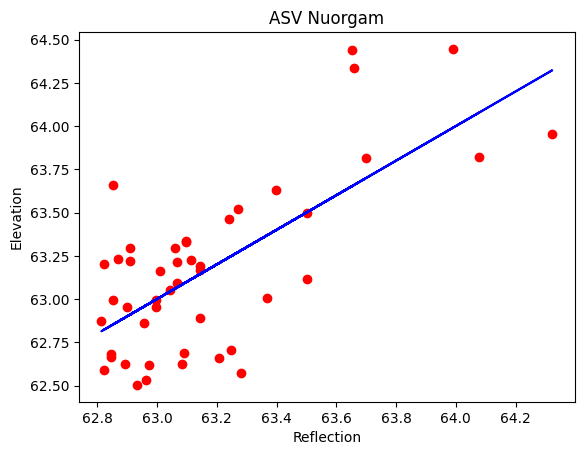

In [42]:
# plot
plt.scatter(x, y, color = 'red')
plt.plot(x, model.predict(x), color = 'blue')
plt.title('ASV Nuorgam')
plt.xlabel('Reflection')
plt.ylabel('Elevation')
plt.show()

In [19]:
# calculate Lyzenga depth using followinf formula: depth = a + b * reflection
n_c['l_depth'] = (-4.21289933) + 126.9836257 * n_c['Band_3']

In [20]:
# check
n_c.head()

,id,SAMPLE_1,ASV,SAMPLE_1_2,Band_2,Band_3,Band_4,Band_8,Band_11,ALS,ASV_mmpy,l_depth
0,0,-1.549120,1.549120,0.1322,0.1244,0.1250,0.1197,0.1176,0.1176,11.667301,11.845880,11.660054
2,2,-1.480504,1.480504,0.1277,0.1254,0.1270,0.1208,0.1172,0.1115,12.021470,11.914496,11.914022
3,3,-1.449683,1.449683,0.1277,0.1256,0.1278,0.1192,0.1142,0.1093,12.537871,11.945317,12.015608
4,4,-2.498674,2.498674,0.1250,0.1246,0.1210,0.1165,0.1122,0.1082,10.869689,10.896326,11.152119
5,5,-2.087731,2.087731,0.1257,0.1258,0.1210,0.1154,0.1116,0.1079,10.489830,11.307269,11.152119


## VALLE

In [21]:
# import VALLE (v) CALIBRATION POINTS (c)
v_c = pd.read_csv('../data/output/satellite-analysis/valle_calibrationpoints.csv', delimiter=',')

In [22]:
# check
v_c.head()

,id,SAMPLE_1,SAMPLE_1_2,SAMPLE_2,SAMPLE_3,SAMPLE_4,SAMPLE_5,SAMPLE_6,SAMPLE_7,SAMPLE_8,...,SAMPLE_20,SAMPLE_21,SAMPLE_22,SAMPLE_23,SAMPLE_1_3,SAMPLE_2_2,SAMPLE_3_2,SAMPLE_4_2,SAMPLE_5_2,SAMPLE_6_2
0,0,-3.307974,0.11950,0.11910,0.11860,0.11145,0.11195,0.11390,0.11650,0.1141,...,0,0,0,0,89.72,90.47,90.320000,90.268192,5,0.300000
1,1,-2.718109,0.12135,0.11975,0.11645,0.11230,0.11365,0.11370,0.11640,0.1137,...,0,0,0,0,73.17,88.28,86.493636,87.036686,11,4.224965
2,2,-2.852675,0.12135,0.11930,0.11710,0.11260,0.11090,0.11295,0.11690,0.1143,...,0,0,0,0,87.88,88.06,87.971429,87.969060,7,0.064681
3,3,-2.520809,0.13140,0.11900,0.12020,0.11320,0.11520,0.11565,0.11840,0.1157,...,0,0,0,0,87.41,89.89,87.941875,87.955593,16,0.551954
4,4,-2.680977,0.12165,0.11700,0.11765,0.11135,0.11175,0.11400,0.11865,0.1133,...,0,0,0,0,87.52,89.81,88.180833,88.180475,12,0.730119


In [23]:
# drop columns
v_c = v_c.drop(columns=
                           [
                            'SAMPLE_5','SAMPLE_6','SAMPLE_7','SAMPLE_9', 'SAMPLE_10',
                            'SAMPLE_12','SAMPLE_13', 'SAMPLE_14', 'SAMPLE_15',
                            'SAMPLE_16', 'SAMPLE_17','SAMPLE_18', 'SAMPLE_19', 
                            'SAMPLE_20','SAMPLE_21', 'SAMPLE_22','SAMPLE_23','SAMPLE_1_3',
                            'SAMPLE_2_2', 'SAMPLE_3_2','SAMPLE_5_2', 'SAMPLE_6_2', 'SAMPLE_1_2'])

In [24]:
# check
v_c.head()

,id,SAMPLE_1,SAMPLE_2,SAMPLE_3,SAMPLE_4,SAMPLE_8,SAMPLE_11,SAMPLE_4_2
0,0,-3.307974,0.11910,0.11860,0.11145,0.1141,0.11065,90.268192
1,1,-2.718109,0.11975,0.11645,0.11230,0.1137,0.11050,87.036686
2,2,-2.852675,0.11930,0.11710,0.11260,0.1143,0.11100,87.969060
3,3,-2.520809,0.11900,0.12020,0.11320,0.1157,0.11345,87.955593
4,4,-2.680977,0.11700,0.11765,0.11135,0.1133,0.11070,88.180475


In [25]:
# rename columns
# Band 2 - Blue
# Band 3 - Green
# Band 4 - Red
# Band 8 - NIR
# Band 11 - SWIR
v_c = v_c.rename(columns={"SAMPLE_1": "ASV", "SAMPLE_2": "Band_2", "SAMPLE_3": "Band_3", "SAMPLE_4": "Band_4", "SAMPLE_8": "Band_8", "SAMPLE_11": "Band_11", "SAMPLE_4_2": "ALS"})

In [26]:
# check
v_c.head()

,id,ASV,Band_2,Band_3,Band_4,Band_8,Band_11,ALS
0,0,-3.307974,0.11910,0.11860,0.11145,0.1141,0.11065,90.268192
1,1,-2.718109,0.11975,0.11645,0.11230,0.1137,0.11050,87.036686
2,2,-2.852675,0.11930,0.11710,0.11260,0.1143,0.11100,87.969060
3,3,-2.520809,0.11900,0.12020,0.11320,0.1157,0.11345,87.955593
4,4,-2.680977,0.11700,0.11765,0.11135,0.1133,0.11070,88.180475


In [27]:
# drop no value rows
v_c = v_c.dropna()

In [28]:
# calculate elevation for asv data
v_c['ASV_mmpy'] = 66.016 + v_c['ASV']

In [29]:
# check
v_c.head()

,id,ASV,Band_2,Band_3,Band_4,Band_8,Band_11,ALS,ASV_mmpy
0,0,-3.307974,0.11910,0.11860,0.11145,0.1141,0.11065,90.268192,62.708026
1,1,-2.718109,0.11975,0.11645,0.11230,0.1137,0.11050,87.036686,63.297891
2,2,-2.852675,0.11930,0.11710,0.11260,0.1143,0.11100,87.969060,63.163325
3,3,-2.520809,0.11900,0.12020,0.11320,0.1157,0.11345,87.955593,63.495191
4,4,-2.680977,0.11700,0.11765,0.11135,0.1133,0.11070,88.180475,63.335023


In [30]:
# start calculating the linear model
x = v_c[['Band_3']]
y = v_c[['ASV_mmpy']]

model.fit(x, y)

r2_score = model.score(x, y)
print(f"R-squared value: {r2_score}")

R-squared value: 0.49308868986734833


In [31]:
# calculate intercept (kulmakerroin, a)
print(model.intercept_)
# calculate coefficient (vakiotermi, b)
print(model.coef_)

[44.51169557]
[[157.98093014]]


In [32]:
# calculate correlation
v_c["Band_3"].corr(v_c["ASV_mmpy"])  

0.7022027412844152

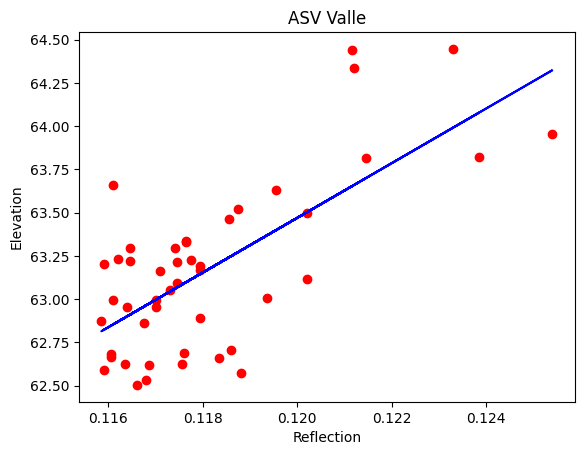

In [33]:
# plot
plt.scatter(x, y, color = 'red')
plt.plot(x, model.predict(x), color = 'blue')
plt.title('ASV Valle')
plt.xlabel('Reflection')
plt.ylabel('Elevation')
plt.show()

In [34]:
# calculate Lyzenga depth using following formula: depth = a + b * reflection
v_c['l_depth'] = 44.51169557 + 157.98093014 * v_c['Band_3']

In [35]:
# check
v_c.head()

,id,ASV,Band_2,Band_3,Band_4,Band_8,Band_11,ALS,ASV_mmpy,l_depth
0,0,-3.307974,0.11910,0.11860,0.11145,0.1141,0.11065,90.268192,62.708026,63.248234
1,1,-2.718109,0.11975,0.11645,0.11230,0.1137,0.11050,87.036686,63.297891,62.908574
2,2,-2.852675,0.11930,0.11710,0.11260,0.1143,0.11100,87.969060,63.163325,63.011263
3,3,-2.520809,0.11900,0.12020,0.11320,0.1157,0.11345,87.955593,63.495191,63.501003
4,4,-2.680977,0.11700,0.11765,0.11135,0.1133,0.11070,88.180475,63.335023,63.098152


R-squared value: 0.49308868986734944


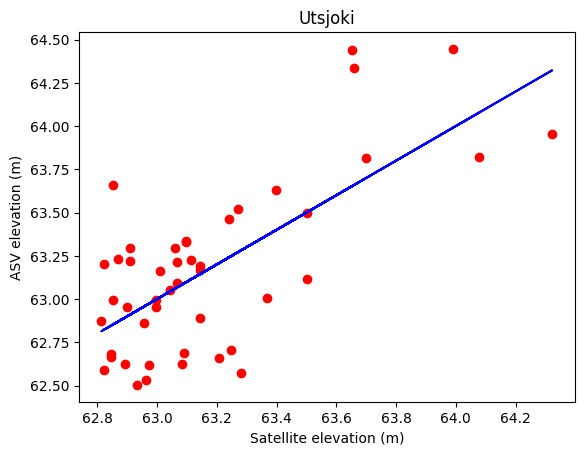

In [37]:
x = v_c[['l_depth']]
y = v_c[['ASV_mmpy']]

model.fit(x, y)

r2_score = model.score(x, y)
print(f"R-squared value: {r2_score}")
# plot
plt.scatter(x, y, color = 'red')
plt.plot(x, model.predict(x), color = 'blue')
plt.title('Utsjoki')
plt.xlabel('Satellite elevation (m)')
plt.ylabel('ASV elevation (m)')
plt.show()